In [1]:
import matplotlib.pyplot as plt
from src.utils.plot_utils import *
from src.utils.sim_utils import *
import yaml
import numpy as np
import jax.numpy as jnp
import sparse
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pathlib import Path, PosixPath
import h5py

os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"

Using diffeqsolve-based neural simulation (original)


In [2]:
# # PLOT defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["xtick.minor.size"] = 1.0
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["xtick.minor.width"] = 0.18
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["figure.dpi"] = 200

plt.rcParams["axes.labelpad"] = 1.5
plt.rcParams["xtick.major.pad"] = 1.5
plt.rcParams["ytick.major.pad"] = 1.5

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"

dataPath = "/data/users/smpuglie/Pugliese_2025/"

## MANC 1024x DNg100 pruning

In [ ]:
simType = "DNg100_Stim_Prune"
simPath = simType+"/hyak/run_id=28965859"
folder = dataPath + simPath
minicircuits = sparse.load_npz(folder+f"/ckpt/{simType}_mini_circuits.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

nRuns = minicircuits.shape[0]

wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])

/home/smpuglie/Pugliese_2025/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [10]:
minicircuitsDf = pd.DataFrame(data=minicircuits,columns = wTable.bodyId)
minicircuitsDf = minicircuitsDf.iloc[:,np.argsort(np.sum(minicircuitsDf.values, 0))]
minicircuitsDf[10093] = False #exclude DNg100
minicircuitsDf[wTable.loc[mnData.index,"bodyId"]] = False # exclude MNs
minicircuitsDf

bodyId,25052,25130,25128,25126,25125,25110,25090,25082,25064,25155,...,10715,12026,21944,19771,13905,19319,11751,12686,10707,10093
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,True,False
1020,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1021,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
1022,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False


In [5]:
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

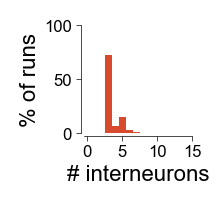

In [6]:
ax = sns.histplot(minicircuitsDf.sum(1),color=excColor,bins=np.arange(90),edgecolor=None,stat="percent",alpha=1,discrete=True)
ax.set_xlim(-0.5,14.5)
# ax.set_xlim(0,30)
# plt.yticks(np.arange(0,20,4))
ax.set_xlabel("# interneurons")
ax.set_ylabel("% of runs")
ax.set_xticks(np.arange(0,16,5))
# ax.set_xticks(np.arange(0,16,1),minor=True,)
ax.tick_params(axis='both', which='major')
ax.spines[["top","right"]].set_visible(False)

plt.ylim([0,100])

fig = plt.gcf()
fig.set_figheight(0.7)
fig.set_figwidth(0.7)
# plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/minicircuitNIns.svg",transparent=True)
plt.show()

In [7]:
minicircuitsDf.sum(1).value_counts().sort_index()

2       6
3     743
4      64
5     158
6      27
7       9
8       6
9       2
10      1
11      1
13      1
14      1
16      1
28      1
29      1
30      1
44      1
Name: count, dtype: int64

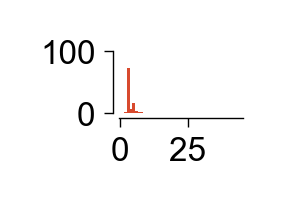

In [8]:
ax = sns.histplot(minicircuitsDf.sum(1),color=excColor,bins=np.arange(0,100,1),edgecolor=None,stat="percent",alpha=1,discrete=True)
# sns.kdeplot(x=minicircuitsDf.sum(1),color=excColor,fill=True,linewidth=0,alpha=0.5,cut=0,ax=ax)
# ax.set_xlim(0,30)
# plt.yticks(np.arange(0,20,4))
ax.set_xlabel("")
ax.set_ylabel("")
# ax.set_xticks(np.arange(0,40,5))
# ax.set_xticks(np.arange(0,40,1),minor=True,)
ax.set_xlim(-0.5,45.5)
ax.tick_params(axis='both', which='major')
ax.spines[["top","right"]].set_visible(False)

plt.ylim([0,100])

fig = plt.gcf()
fig.set_figheight(0.2)
fig.set_figwidth(0.4)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/minicircuitNInsZoomedOut.svg",transparent=True)
plt.show()

In [9]:
orderedInPrevalences = minicircuitsDf.transpose().sum(1).sort_values(ascending=False)
orderedInPcts = orderedInPrevalences / nRuns * 100
orderedInNts = orderedInPcts.index.map(dict(zip(wTable["bodyId"],wTable["predictedNt"])))
orderedInTypes = orderedInPcts.index.map(dict(zip(wTable["bodyId"],wTable["type"])))
ntColors = {"acetylcholine":excColor,"gaba":inhColor,"glutamate":inhColor}
orderedColors = orderedInNts.map(ntColors)

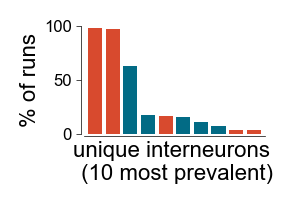

In [10]:
fig = plt.figure()
ax = orderedInPcts[:10].plot.bar(color=orderedColors[:10],width=0.8,rot=90)
plt.xticks([])
plt.ylabel("% of runs")
plt.xlabel("unique interneurons \n (10 most prevalent)")

plt.ylim([0,100])

ax.spines[["top","right"]].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=6)
fig.set_figheight(0.7)
fig.set_figwidth(1.172)
# fig.set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/minicircuitUniqueIns.svg",transparent=True)
plt.show()

In [18]:
print(orderedInTypes.tolist())

['IN17A001', 'INXXX466', 'IN16B036', 'IN13A010', 'IN19B012', 'MNfl10', 'IN19A007', 'IN19A020', 'INXXX464', 'IN03A067', 'IN01A015', 'IN19A008', 'IN09A002', 'IN16B042', 'IN03A088', 'IN03A067', 'IN13B078', 'IN21A007', 'IN16B042', 'IN16B016', 'IN17A022', 'IN13B078', 'IN09A012', 'IN12B025', 'IN14A076', 'IN09A083', 'IN09A006', 'IN13B056', 'IN13A050', 'IN13A001', 'AN12B060', 'IN09A064', 'IN09A061', 'IN21A024', 'IN12B025', 'IN08A007', 'IN14B010', 'IN19B005', 'IN13B004', 'IN09A045', 'AN12B060', 'IN13A014', 'IN19A010', 'IN12B043', 'IN19A016', 'AN08B022', 'IN09A047', 'IN09A048', 'IN12B044', 'IN23B028', 'IN12B003', 'IN12B030', 'IN08A030', 'IN13B090', 'IN19A021', 'IN16B029', 'IN19A029', 'IN03A006', 'IN13A008', 'IN03A039', 'IN21A001', 'IN01A002', 'IN13A051', 'IN13A051', 'IN08A002', 'IN13B087', 'IN21A008', 'IN19A016', 'IN13A037', 'AN19B004', 'IN07B002', 'IN08B001', 'DNut046', 'IN27X002', 'DNxl080', 'AN02A001', 'IN01A001', 'IN07B001', 'DNp18', 'AN19B001', 'IN07B001', 'IN14A012', 'DNp18', 'vMS16', 'INX

### supplemental table

In [26]:
distinctCircuits = pd.Series()
for idx in minicircuitsDf.index:
    tmp = minicircuitsDf.loc[idx]
    distinctCircuits.loc[idx] = sorted(tmp[tmp].index.to_list())
distinctCircuits

0                                   [10707, 11751, 13905]
1                                   [10707, 11751, 13905]
2                                   [10242, 10707, 11751]
3                                   [10707, 11751, 13905]
4                                   [10707, 11751, 13905]
                              ...                        
1019    [10342, 10707, 11425, 11751, 12026, 15452, 202...
1020                                [10242, 10707, 11751]
1021                                [10707, 11751, 13905]
1022                        [10707, 11751, 11799, 163105]
1023                  [10707, 10715, 11751, 12026, 17664]
Length: 1024, dtype: object

In [88]:
commonCircuits = pd.DataFrame(distinctCircuits.value_counts())[pd.DataFrame(distinctCircuits.value_counts())>=10].dropna().astype(int)

In [89]:
def bodyIdToIdx(wTable,bodyIdList):
    return wTable[wTable["bodyId"].isin(bodyIdList)].index.to_numpy().astype(int)

commonCircuits.insert(0,"types",[""]*len(commonCircuits))

for i in range(len(commonCircuits)):
    commonCircuits["types"].iloc[i] = str(wTable.loc[bodyIdToIdx(wTable,commonCircuits.index[i]),"type"].tolist())

/tmp/ipykernel_2648068/1876734935.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  commonCircuits["types"].iloc[i] = str(wTable.loc[bodyIdToIdx(wTable,commonCircuits.index[i]),"type"].tolist())
/tmp/ipykernel_2648068/1876734935.py:7: Sett

In [90]:
commonCircuits.index = commonCircuits.index.astype(str)

In [91]:
print(commonCircuits.to_latex(index=True))

\begin{tabular}{llr}
\toprule
 & types & count \\
\midrule
[10707, 11751, 13905] & ['IN17A001', 'INXXX466', 'IN16B036'] & 636 \\
[10707, 10715, 11751, 12026, 17664] & ['IN17A001', 'IN19B012', 'INXXX466', 'IN13A010', 'MNfl10'] & 123 \\
[10242, 10707, 11751] & ['IN19A007', 'IN17A001', 'INXXX466'] & 102 \\
[10707, 10715, 11751, 12026] & ['IN17A001', 'IN19B012', 'INXXX466', 'IN13A010'] & 33 \\
[10707, 11751, 11799, 17664, 162543] & ['IN17A001', 'INXXX466', 'IN19A020', 'MNfl10', 'INXXX464'] & 11 \\
\bottomrule
\end{tabular}



In [95]:
wTable.loc[wTable['bodyId']==11799]

,Unnamed: 0,bodyId,type,class,subclass,hemilineage,size,predictedNt,predictedNtProb,ntAcetylcholineProb,ntGabaProb,ntGlutamateProb,somaSide,motor module,step contribution
630,630,11799,IN19A020,intrinsic neuron,IR,19A,2341718727,gaba,0.757781,0.009615,0.760016,0.22679,LHS,NaN,NaN


## FANC 1024x DNg100 pruning

In [96]:
simType = "DNg100_Stim_Prune_FANC"
simPath = simType+"/hyak/run_id=28940609/experiment.seed=1"
folder = dataPath + simPath
minicircuits = sparse.load_npz(folder+f"/ckpt/{simType}_mini_circuits.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

# dataset = 0
# minicircuits = minicircuits[dataset]
nRuns = minicircuits.shape[0]

try:
    wTable = pd.read_csv(".."+params.experiment["dfPath"].split("Pugliese_2025")[1])
except:
    wTable = pd.read_csv(".."+params.experiment["dfPath"].split("Pugliese_2025")[1].replace('t1 ','t1l ')) # folder name discrepancy....
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])

/home/smpuglie/Pugliese_2025/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [97]:
minicircuitsDf = pd.DataFrame(data=minicircuits,columns = wTable.pt_supervoxel_id)
minicircuitsDf = minicircuitsDf.iloc[:,np.argsort(np.sum(minicircuitsDf.values, 0))]
minicircuitsDf[73115599907537415] = False #exclude DNg100
minicircuitsDf[wTable.loc[mnData.index,"pt_supervoxel_id"]] = False # exclude MNs...
minicircuitsDf

pt_supervoxel_id,72553749398438996,72483380721452845,72413011977281631,72483449440955806,72413080696826881,72413149483537745,72483449373840157,72483449373837839,72483380721429396,72483449373863532,...,72975343790906622,73116080876550816,72764168838880663,72834468863862859,72834537583100984,72904974778207768,72693868747178343,72834674820722635,73115599907537415,72975481296715415
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
1020,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
1021,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
1022,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True


In [98]:
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

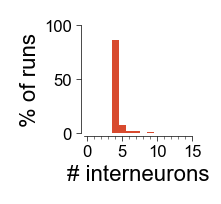

In [99]:
ax = sns.histplot(minicircuitsDf.sum(1),color=excColor,bins=np.arange(90),edgecolor=None,stat="percent",alpha=1,discrete=True)
ax.set_xlim(-0.5,14.5)
# ax.set_xlim(0,30)
# plt.yticks(np.arange(0,20,4))
ax.set_xlabel("# interneurons")
ax.set_ylabel("% of runs")
ax.set_xticks(np.arange(0,16,5))
ax.set_xticks(np.arange(0,16,1),minor=True,)
ax.tick_params(axis='both', which='major')
ax.spines[["top","right"]].set_visible(False)

plt.ylim([0,100])

fig = plt.gcf()
fig.set_figheight(0.7)
fig.set_figwidth(0.7)
# plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/minicircuitNIns.svg",transparent=True)
plt.show()

In [100]:
minicircuitsDf.sum(1).value_counts().sort_index()

0       2
4     881
5      80
6      16
7      22
8       5
9       7
10      6
11      2
12      1
13      1
18      1
Name: count, dtype: int64

In [101]:
orderedInPrevalences = minicircuitsDf.transpose().sum(1).sort_values(ascending=False)
orderedInPcts = orderedInPrevalences / nRuns * 100
orderedInSigns = orderedInPcts.index.map(dict(zip(wTable["pt_supervoxel_id"],wTable["sign"])))
orderedInTypes = orderedInPcts.index.map(dict(zip(wTable["pt_supervoxel_id"],wTable["w_type"])))
signColors = {1:excColor,-1:inhColor}
orderedColors = orderedInSigns.map(signColors)

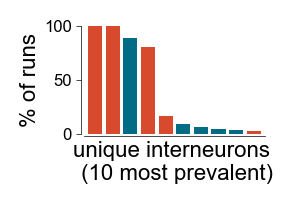

In [102]:
fig = plt.figure()
ax = orderedInPcts[:10].plot.bar(color=orderedColors[:10],width=0.8,rot=90)
plt.xticks([])
plt.ylabel("% of runs")
plt.xlabel("unique interneurons \n (10 most prevalent)")

plt.ylim([0,100])

ax.spines[["top","right"]].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=6)
fig.set_figheight(0.7)
fig.set_figwidth(1.172)
# fig.set_dpi(400)

sns.despine(offset=1)
plt.gca().tick_params(axis="x",labelrotation=90)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/minicircuitUniqueIns.svg",transparent=True)
plt.show()

### supplemental table

In [121]:
distinctCircuits = pd.Series()
for idx in minicircuitsDf.index:
    tmp = minicircuitsDf.loc[idx]
    distinctCircuits.loc[idx] = sorted(tmp[tmp].index.to_list())
distinctCircuits

0       [72483380721505294, 72834674820722635, 7297548...
1       [72483380721505294, 72834674820722635, 7290511...
2       [72694075576809644, 72834674820722635, 7297548...
3       [72483380721505294, 72834674820722635, 7297548...
4       [72483380721505294, 72834674820722635, 7297548...
                              ...                        
1019    [72483380721505294, 72834674820722635, 7297548...
1020    [72483380721505294, 72834674820722635, 7297548...
1021    [72483380721505294, 72834674820722635, 7297548...
1022    [72483380721505294, 72834674820722635, 7297548...
1023    [72483380721505294, 72834674820722635, 7290511...
Length: 1024, dtype: object

In [122]:
commonCircuits = pd.DataFrame(distinctCircuits.value_counts())[pd.DataFrame(distinctCircuits.value_counts())>=10].dropna().astype(int)

In [123]:
def segIdToIdx(wTable,bodyIdList):
    return wTable.iloc[pd.Index(wTable['pt_supervoxel_id']).get_indexer(bodyIdList)].index.to_numpy().astype(int)

commonCircuits.insert(0,"types",[""]*len(commonCircuits))

for i in range(len(commonCircuits)):
    commonCircuits["types"].iloc[i] = str(wTable.loc[segIdToIdx(wTable,commonCircuits.index[i]),"w_type"].tolist())

/tmp/ipykernel_2648068/3765563428.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  commonCircuits["types"].iloc[i] = str(wTable.loc[segIdToIdx(wTable,commonCircuits.index[i]),"w_type"].tolist())
/tmp/ipykernel_2648068/3765563428.py:7: Set

In [125]:
commonCircuits.index = commonCircuits.index.astype(str)
display(commonCircuits)
print(commonCircuits.to_latex(index=True))

,types,count
"[72483380721505294, 72834674820722635, 72975481296715415, 73820799177797612]","['19A', '17A', 'TBD', '19B']",721
"[72483380721505294, 72834674820722635, 72905112552773752, 72975481296715415]","['19A', '17A', 'TBD', 'TBD']",89
"[72694075576809644, 72834674820722635, 72975481296715415, 73820799177797612]","['13A', '17A', 'TBD', '19B']",36
"[72483380721505294, 72834674820722635, 72905112552773752, 72975481296715415, 72975481364113281]","['19A', '17A', 'TBD', 'TBD', '08A']",25
"[72834674820722635, 72905112619913957, 72975481296715415, 73820799177797612]","['17A', '08A', 'TBD', '19B']",15
"[72483380721505294, 72834674820722635, 72975481296715415, 73891167921933971]","['19A', '17A', 'TBD', '19B']",13
"[72483380721505294, 72834674820722635, 72905112552773752, 72975481296715415, 73468887542677672]","['19A', '17A', 'TBD', 'TBD', '12B']",13


\begin{tabular}{llr}
\toprule
 & types & count \\
\midrule
[72483380721505294, 72834674820722635, 72975481296715415, 73820799177797612] & ['19A', '17A', 'TBD', '19B'] & 721 \\
[72483380721505294, 72834674820722635, 72905112552773752, 72975481296715415] & ['19A', '17A', 'TBD', 'TBD'] & 89 \\
[72694075576809644, 72834674820722635, 72975481296715415, 73820799177797612] & ['13A', '17A', 'TBD', '19B'] & 36 \\
[72483380721505294, 72834674820722635, 72905112552773752, 72975481296715415, 72975481364113281] & ['19A', '17A', 'TBD', 'TBD', '08A'] & 25 \\
[72834674820722635, 72905112619913957, 72975481296715415, 73820799177797612] & ['17A', '08A', 'TBD', '19B'] & 15 \\
[72483380721505294, 72834674820722635, 72975481296715415, 73891167921933971] & ['19A', '17A', 'TBD', '19B'] & 13 \\
[72483380721505294, 72834674820722635, 72905112552773752, 72975481296715415, 73468887542677672] & ['19A', '17A', 'TBD', 'TBD', '12B'] & 13 \\
\bottomrule
\end{tabular}



```
72483380721505294, 72834674820722635, 72975481296715415, 73820799177797612 & IN19A007~(I2), IN17A001~(E1), INXXX466~(E2), IN19B012~(+) & 721 \\
72483380721505294, 72834674820722635, 72905112552773752, 72975481296715415 & IN19A007~(I2), IN17A001~(E1), INXXX464~(E4), INXXX466~(E2) & 89 \\
72694075576809644, 72834674820722635, 72975481296715415, 73820799177797612 & IN13A010~(--), IN17A001~(E1), INXXX466~(E2), IN19B012~(+) & 36 \\
72483380721505294, 72834674820722635, 72905112552773752, 72975481296715415, 72975481364113281 & IN19A007~(I2), IN17A001~(E1), INXXX464~(E4), INXXX466~(E2), 8A~(--) & 25 \\
72834674820722635, 72905112619913957, 72975481296715415, 73820799177797612 & IN17A001~(E1), IN16B036~(I1), INXXX466~(E2), IN19B012~(+) & 15 \\
72483380721505294, 72834674820722635, 72975481296715415, 73891167921933971 & IN19A007~(I2), IN17A001~(E1), INXXX466~(E2), 19B~(+) & 13 \\
72483380721505294, 72834674820722635, 72905112552773752, 72975481296715415, 73468887542677672 & IN19A007~(I2), IN17A001~(E1), INXXX464~(E4), INXXX466~(E2), 12B~(--) & 13 \\
```

72483380721505294: ['19A', -1]   IN19A007~(I2)

72694075576809644: ['13A', -1]   IN13A010~(--)

72834674820722635: ['17A', 1]   IN17A001~(E1)

72834743473229644: ['17A', 1]   17A~(+)

72905112552773752: ['08A', -1]   INXXX464~(E4)

72905112619913957: ['08A', -1]  IN16B036~(I1)

72975481296715415: ['X', 1]   INXXX466~(E2)

73116494267368779: ['13B', -1]   13B~(--)

73820799177797612: ['19B', 1]   IN19B012~(+)

In [126]:
wTable.loc[segIdToIdx(wTable,[73468887542677672])]

,Unnamed: 0,index,id,created,superceded_id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position_nrn,w_type,sign,w_idx,pt_position_soma,surf_area_um2,motor module,step contribution,class
234,234,233,2376,2024-01-08 20:53:18.085962+00:00,NaN,t,12B,12B,73468887542677672,648518346479572672,[ 41176 118750 3164],12B,-1,234,[ 42208 119456 3719],19276.712708,NaN,NaN,intrinsic neuron


## MANC 1024x core CPG only

In [3]:
simType = "DNg100_Stim_CoreCPG"
simPath = simType+"/hyak/run_id=29236830"
folder = dataPath + simPath
subfolders = []
for f in os.listdir(folder):
    if os.path.isdir(f"{folder}/{f}"):
        subfolders.append(f)
params = DictConfig(load_from_yaml(folder+"/multirun.yaml"))

dataset = 0

Rs = None

for subfolder in subfolders:
    if Rs is None:
        Rs = sparse.load_npz(f"{folder}/{subfolder}/ckpt/{simType}_Rs.npz").todense()
        Rs = Rs[dataset]
    else:
        batchRs = sparse.load_npz(f"{folder}/{subfolder}/ckpt/{simType}_Rs.npz").todense()
        batchRs = batchRs[dataset]
        Rs = np.concatenate([Rs,batchRs],axis=0)
        del batchRs
    
nSims = Rs.shape[0]
Rs.shape

(1024, 4604, 2001)

In [4]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[:,250:],activeMnsMaskPastTransient)
    simScore.loc[i] = score
    
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

/home/smpuglie/Pugliese_2025/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


### individual traces

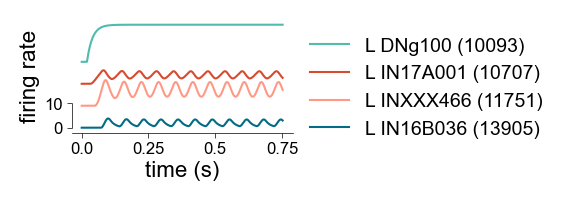

178
0.9994075298309326


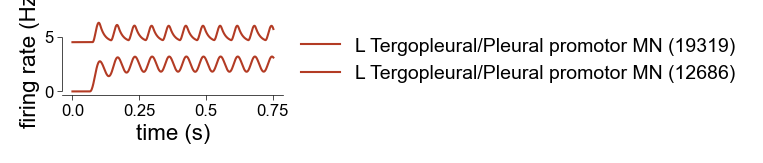

In [9]:
coreCpgData = wTable.loc[params.experiment.keepOnly]
coreCpgData.loc[31,"somaSide"] = "LHS"

idx = np.random.randint(1000) 
spacer = 9
width = 3

R = Rs[idx]

plt.figure()
ax = plot_R_traces_stacked_2(R[:,:750],coreCpgData,activeOnly=False,space=spacer,colors=[dnColor,excColor,lightExcColor,inhColor])
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,10,"k",linewidth=0.25)
plt.yticks([0,10])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.tick_params(labelsize=6)
ax.grid(False)
# plt.ylabel("firing rate (Hz)",fontsize=8)
plt.xlabel("time (s)")
fig = plt.gcf()
fig.set_figwidth(1.426)
fig.set_figheight(1.226*3/5)



plt.show()

spacer = 4.5
plt.figure()
print(idx)
ax = plot_R_traces_stacked_by_module(R[:,:750],mnData,activeOnly=True,space=spacer)# ,colorMapper=colorMapper)
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,5,"k",linewidth=0.25)
plt.yticks([0,5])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.tick_params(labelsize=6)
ax.grid(False)
# plt.ylabel("firing rate (Hz)",fontsize=8)
plt.xlabel("time (s)")
fig = plt.gcf()

fig.set_figwidth(1.426)
fig.set_figheight(1.226*2/5)

print(simScore[idx])



plt.show()

901,178

In [10]:
i=178

display(get_active_data(Rs[i],wTable))
print(sum(get_active_data(Rs[i],wTable)["class"]=="motor neuron"))

,Unnamed: 0,bodyId,type,class,subclass,hemilineage,size,predictedNt,predictedNtProb,ntAcetylcholineProb,ntGabaProb,ntGlutamateProb,somaSide,motor module,step contribution
31,31,10093,DNg100,descending neuron,xl,NaN,7124816452,acetylcholine,0.957519,0.957519,0.013868,0.025821,NaN,NaN,NaN
277,277,10707,IN17A001,intrinsic neuron,IR,17A,3939072421,acetylcholine,0.915736,0.916041,0.008723,0.072385,LHS,NaN,NaN
617,617,11751,INXXX466,intrinsic neuron,IR,TBD,2180476120,acetylcholine,0.903543,0.904158,0.016817,0.075691,LHS,NaN,NaN
860,860,12686,Tergopleural/Pleural promotor MN,motor neuron,fl,TBD,2832306624,glutamate,0.373590,0.198403,0.288615,0.373630,LHS,coxa swing,swing
1167,1167,13905,IN16B036,intrinsic neuron,IR,16B,1314155373,glutamate,0.953745,0.010699,0.032117,0.953745,LHS,NaN,NaN
2222,2222,19319,Tergopleural/Pleural promotor MN,motor neuron,fl,TBD,1808715358,glutamate,0.423431,0.117247,0.227515,0.481648,LHS,coxa swing,swing


2


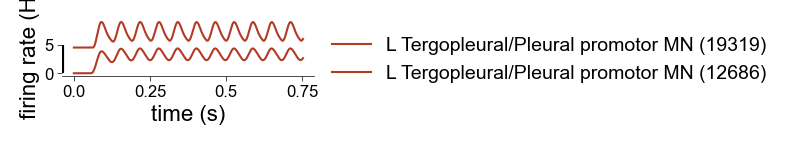

In [13]:
idx = 901 #np.random.randint(nSims)
spacer = 4.5
scalebar = 5

timeLimit = .75

R = Rs[idx]

plt.figure()
ax = plot_R_traces_stacked_by_module(R[:,:750],mnData,activeOnly=True,space=spacer)
add_tAxis(ax,timeLimit,3.00001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,scalebar,"k")
plt.yticks([0,scalebar])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
fig = plt.gcf()
ax.grid(False)
plt.xlabel("time (s)")


fig.set_figwidth(1.626)
fig.set_figheight(1.1/3)
# fig.set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/mnTraces_idx{idx}.svg",transparent=True)
plt.show()

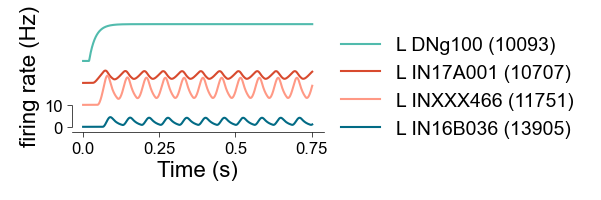

In [14]:
idx = 901 # np.random.randint(1000)
R = Rs[idx]
spacer=10

tIdxs = np.arange(0,1000)

coreCpgData = wTable.loc[params.experiment.keepOnly]
coreCpgData.loc[31,"somaSide"] = "LHS"

plt.figure()
ax = plot_R_traces_stacked_2(R[:,:750],coreCpgData,activeOnly=True,space=spacer,colors=[dnColor,excColor,lightExcColor,inhColor])
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,10,"k",linewidth=0.25)
plt.yticks([0,10])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.grid(False)
plt.ylabel("firing rate (Hz)")
fig = plt.gcf()

fig.set_figwidth(1.626)
fig.set_figheight(1.1*2/3)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/dng100trace_idx{idx}.svg",transparent=True)
plt.show()

### overall data

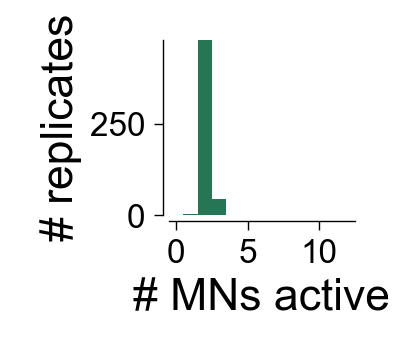

In [15]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,480])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10],labels=[0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

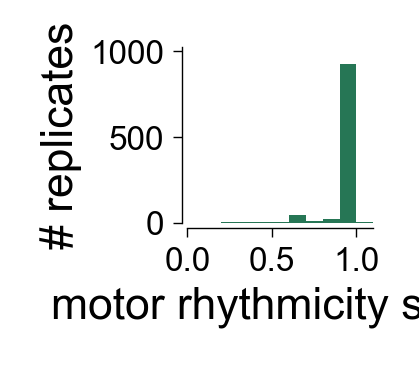

In [16]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

## MANC 1024x DNg100 activation with CPG IN silencing

### E1 silencing

In [3]:
simType = "DNg100_Stim_Silence"
simPath = simType+"/hyak/run_id=28357120"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 4604, 2001)

In [4]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[:,250:],activeMnsMaskPastTransient)
    simScore.loc[i] = score
    
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

nMnsActive_e1silenced = nMnsActive.copy()
simScore_e1silenced = simScore.copy()

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [5]:
del R
del Rs
del activeMnsMask
del activeMnsMaskPastTransient

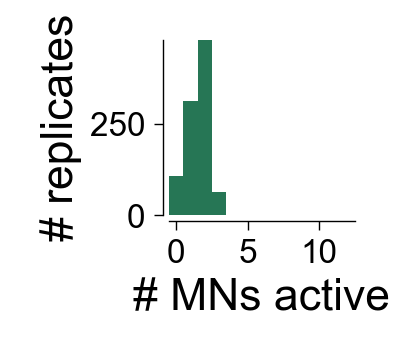

In [6]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,480])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10],labels=[0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

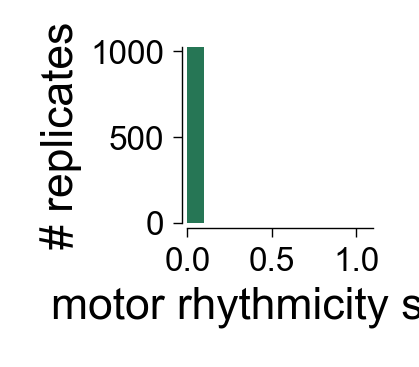

In [7]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

### E2 silencing

In [6]:
simType = "DNg100_Stim_Silence"
simPath = simType+"/hyak/run_id=28357126"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 4604, 2001)

In [7]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[:,250:],activeMnsMaskPastTransient)
    simScore.loc[i] = score
    
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

nMnsActive_e2silenced = nMnsActive.copy()
simScore_e2silenced = simScore.copy()

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [8]:
del R
del Rs
del activeMnsMask
del activeMnsMaskPastTransient

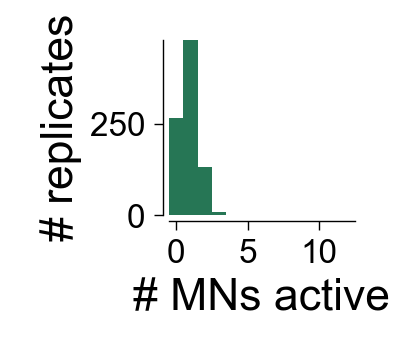

In [10]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,480])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10],labels=[0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

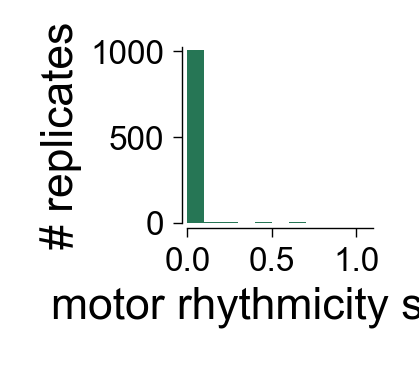

In [13]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

### I1 silencing

In [9]:
simType = "DNg100_Stim_Silence"
simPath = simType+"/hyak/run_id=28357127"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 4604, 2001)

In [10]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[:,250:],activeMnsMaskPastTransient)
    simScore.loc[i] = score
    
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

nMnsActive_i1silenced = nMnsActive.copy()
simScore_i1silenced = simScore.copy()

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [11]:
del R
del Rs
del activeMnsMask
del activeMnsMaskPastTransient

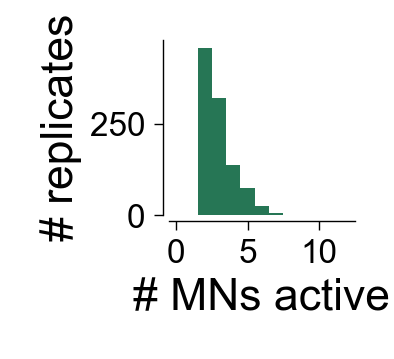

In [17]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,480])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10],labels=[0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

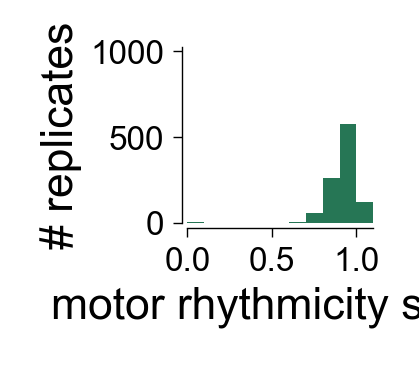

In [18]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

### combined violin plot

In [ ]:
# simType = "DNg100_Stim"
# simPath = simType+"/hyak/run_id=28123286"
# folder = dataPath + simPath
# Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
# params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

# dataset = 0
# Rs = Rs[dataset]
# nSims = Rs.shape[0]
# Rs.shape
# wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
# mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
# nMnsActive_intact = pd.Series(index=np.arange(nSims))
# simScore_intact = pd.Series(index=np.arange(nSims))

# for i in range(nSims):
#     R = Rs[i]
    
#     activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
#     nMnsActive_intact.loc[i] = np.sum(activeMnsMask)
#     activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
#     score, _ = compute_oscillation_score(R[:,250:],activeMnsMaskPastTransient)
#     simScore_intact.loc[i] = score

# nMnsActive_combined = pd.concat([nMnsActive_intact,nMnsActive_e1silenced,nMnsActive_e2silenced,nMnsActive_i1silenced],axis=1).rename(columns={0:"none",1:"E1",2:"E2",3:"I1"})
# simScore_combined = pd.concat([simScore_intact,simScore_e1silenced,simScore_e2silenced,simScore_i1silenced],axis=1).rename(columns={0:"none",1:"E1",2:"E2",3:"I1"})

# figFolder = "../figures/"
# figFolder += "DNg100_Stim_Silence-combined"

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [3]:
nMnsActive_combined = pd.read_csv("../figures/DNg100_Stim_Silence-combined/nMnsActive.csv",index_col=0)
simScore_combined = pd.read_csv("../figures/DNg100_Stim_Silence-combined/scores.csv",index_col=0)

figFolder = "../figures/"
figFolder += "DNg100_Stim_Silence-combined"

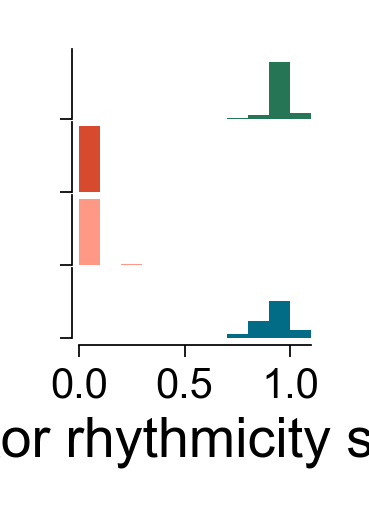

In [6]:
palette = [mnColor,excColor,lightExcColor,inhColor]

fig, axes = plt.subplots(4,1,sharex=True,sharey=True,gridspec_kw={"hspace":0.05},) #-0.4
fig.patch.set_alpha(0)
sns.histplot(simScore_combined["none"],color=mnColor,ax=axes[0],edgecolor=None,bins=np.arange(0,1.5,0.1),alpha=1)
axes[0].patch.set_alpha(0)

sns.histplot(simScore_combined["E1"],color=excColor,ax=axes[1],edgecolor=None,bins=np.arange(0,1.5,0.1),alpha=1)
axes[1].patch.set_alpha(0)

sns.histplot(simScore_combined["E2"],color=lightExcColor,ax=axes[2],edgecolor=None,bins=np.arange(0,1.5,0.1),alpha=1)
axes[2].patch.set_alpha(0)

sns.histplot(simScore_combined["I1"],color=inhColor,ax=axes[3],edgecolor=None,bins=np.arange(0,1.5,0.1),alpha=1)
axes[3].patch.set_alpha(0)

sns.despine(offset=1)

# plt.gca().set_yticks([0,500,1000])
plt.xlabel("motor rhythmicity score")
plt.xlim([0,1.1])
plt.xticks([0,0.5,1])
plt.yticks([0],labels=[])

fig.set_figwidth(0.6)
fig.set_figheight(0.75)
plt.ylabel("")

for i in range(3):
    axes[i].spines["bottom"].set_visible(False)
    axes[i].tick_params(axis="x",color="none")
    axes[i].set_ylabel("")

fig.set_dpi(500)
if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreStackedHists.svg",transparent=True)
plt.show()

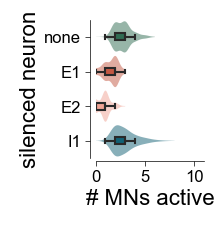

In [21]:
palette = [mnColor,excColor,lightExcColor,inhColor]

plt.figure(figsize=(0.7,0.9))
sns.violinplot(nMnsActive_combined,orient="h",palette=palette,edgecolor=None,inner=None,bw_adjust=2,cut=0,alpha=0.5,width=0.9)
sns.boxplot(nMnsActive_combined,palette=palette,width=0.2,linewidth=0.75,fliersize=2**0.75,orient="h",
            boxprops={"alpha":1.0,},showfliers=False)
plt.xticks([0,5,10])
plt.xlim([0,11])
sns.despine(offset={"left":2,"bottom":1})
plt.xlabel("# MNs active")
plt.ylabel("silenced neuron")

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnViolinAndBoxHorTaller.svg",transparent=True)
plt.show()

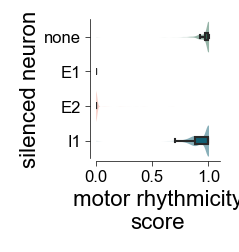

In [15]:
palette = [mnColor,excColor,lightExcColor,inhColor]

plt.figure(figsize=(0.8,0.9))

sns.violinplot(simScore_combined,palette=palette,linecolor="k",linewidth=0,inner=None,cut=0,alpha=0.5,orient="h",width=0.9)
sns.boxplot(simScore_combined,palette=palette,width=0.2,linewidth=0.75,fliersize=2**0.75,
            boxprops={"alpha":1.0,},showfliers=False,orient="h")
plt.xlim([0,1.1])
plt.xlabel("motor rhythmicity\nscore")
plt.xticks(np.arange(0,1.1,0.5))
plt.ylabel("silenced neuron")
sns.despine(offset={"left":2,"bottom":1})

# plt.gcf().set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreViolinAndBoxHorTaller.svg",transparent=True)
plt.show()

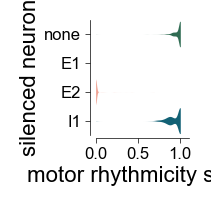

In [16]:
palette = [mnColor,excColor,lightExcColor,inhColor]

plt.figure(figsize=(0.6,0.75))

sns.violinplot(simScore_combined,palette=palette,linecolor="k",linewidth=0,inner=None,cut=0,alpha=1.0,orient="h",width=0.9)
# sns.boxplot(simScore_combined,palette=palette,width=0.2,linewidth=0.75,fliersize=2**0.75,
#             boxprops={"alpha":1.0,},showfliers=False,orient="h")
plt.xlim([0,1.1])
plt.xlabel("motor rhythmicity score")
plt.xticks(np.arange(0,1.1,0.5))
plt.ylabel("silenced neuron")
sns.despine(offset={"left":2,"bottom":1})

# plt.gcf().set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreViolin_20250908.svg",transparent=True)
plt.show()

In [16]:
nMnsActive_combined.to_csv(figFolder+"/nMnsActive.csv")
simScore_combined.to_csv(figFolder+"/scores.csv")

## FANC 1024x DNg100 activation with CPG IN silencing

### individual silencing load / plot

#### E1 silencing

In [4]:
simType = "DNg100_Stim_FANC"
simPath = simType+"/hyak/run_id=28989998/experiment.removeNeurons=[481],experiment.seed=159"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 803, 2001)

In [5]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[:,250:],activeMnsMaskPastTransient)
    simScore.loc[i] = score
    
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

nMnsActive_e1silenced = nMnsActive.copy()
simScore_e1silenced = simScore.copy()

/home/smpuglie/Pugliese_2025/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [6]:
del R
del Rs
del activeMnsMask
del activeMnsMaskPastTransient

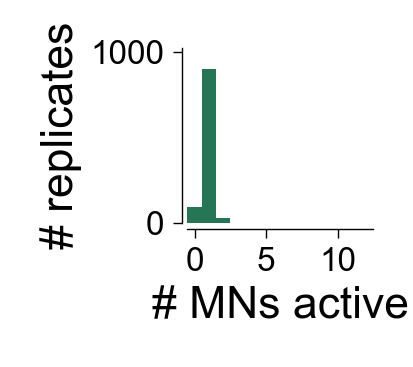

In [9]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

# plt.ylim([0,480])
plt.ylim([0,1024])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10],labels=[0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

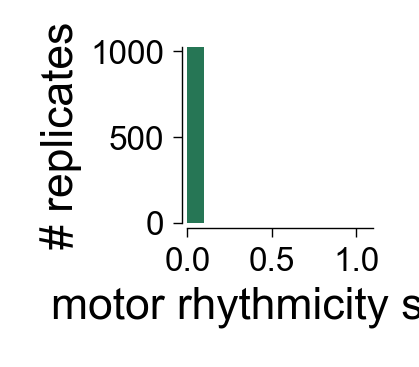

In [10]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

#### E2 silencing

In [11]:
simType = "DNg100_Stim_FANC"
simPath = simType+"/hyak/run_id=28989998/experiment.removeNeurons=[413],experiment.seed=159"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 803, 2001)

In [12]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[:,250:],activeMnsMaskPastTransient)
    simScore.loc[i] = score
    
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

nMnsActive_e2silenced = nMnsActive.copy()
simScore_e2silenced = simScore.copy()

/home/smpuglie/Pugliese_2025/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [13]:
del R
del Rs
del activeMnsMask
del activeMnsMaskPastTransient

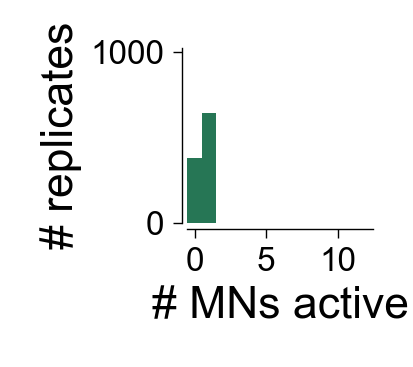

In [15]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,1024])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10],labels=[0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

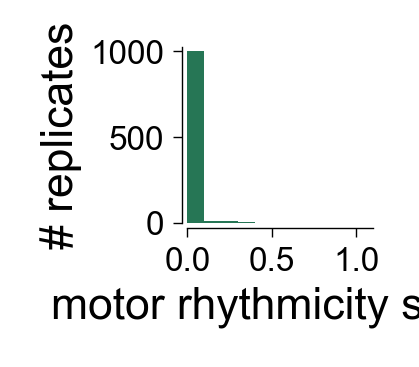

In [16]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

#### I2 silencing

In [17]:
simType = "DNg100_Stim_FANC"
simPath = simType+"/hyak/run_id=28989998/experiment.removeNeurons=[503],experiment.seed=159"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 803, 2001)

In [19]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nActive_i2silenced = pd.Series(index=np.arange(nSims))
nMnsActive = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    R = Rs[i]
    nActive_i2silenced.loc[i] = sum(np.max(R,1)>0.01)
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[:,250:],activeMnsMaskPastTransient)
    simScore.loc[i] = score
    
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

nMnsActive_i2silenced = nMnsActive.copy()
simScore_i2silenced = simScore.copy()

/home/smpuglie/Pugliese_2025/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [20]:
del R
del Rs
del activeMnsMask
del activeMnsMaskPastTransient

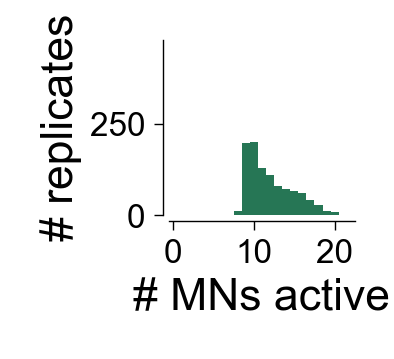

In [25]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,480])
plt.xticks(np.arange(0,30,10))
plt.xlim([-0.5,22.5])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

In [23]:
nMnsActive.value_counts().sort_index()

8.0      13
9.0     199
10.0    201
11.0    130
12.0    109
13.0     80
14.0     73
15.0     67
16.0     61
17.0     42
18.0     27
19.0     11
20.0     10
21.0      1
Name: count, dtype: int64

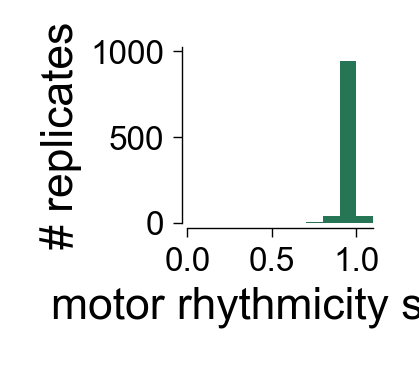

In [26]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

#### IN19B012 silencing

In [27]:
simType = "DNg100_Stim_FANC"
simPath = simType+"/hyak/run_id=28989998/experiment.removeNeurons=[525],experiment.seed=159"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 803, 2001)

In [28]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nActive_19bsilenced = pd.Series(index=np.arange(nSims))
nMnsActive = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    R = Rs[i]
    nActive_19bsilenced.loc[i] = sum(np.max(R,1)>0.01)
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[:,250:],activeMnsMaskPastTransient)
    simScore.loc[i] = score
    
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

nMnsActive_19bsilenced = nMnsActive.copy()
simScore_19bsilenced = simScore.copy()

/home/smpuglie/Pugliese_2025/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [29]:
del R
del Rs
del activeMnsMask
del activeMnsMaskPastTransient

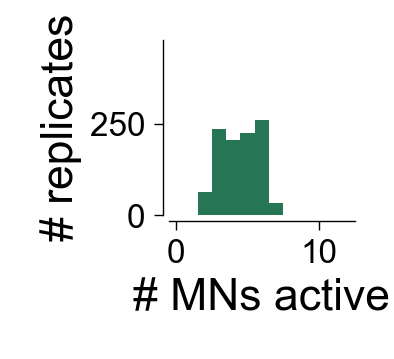

In [31]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,480])
plt.xticks(np.arange(0,30,10))
plt.xlim([-0.5,12.5])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

In [32]:
nMnsActive.value_counts().sort_index()

1.0      1
2.0     63
3.0    235
4.0    205
5.0    226
6.0    260
7.0     34
Name: count, dtype: int64

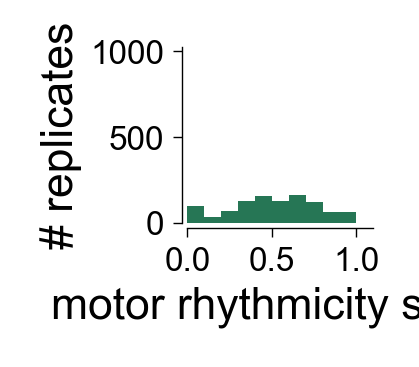

In [33]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

### combined violin plot

In [3]:
# simType = "DNg100_Stim_FANC"
# simPath = simType+"/hyak/run_id=28989998/experiment.removeNeurons=[],experiment.seed=159"
# folder = dataPath + simPath
# Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
# params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

# dataset = 0
# Rs = Rs[dataset]
# nSims = Rs.shape[0]
# Rs.shape

# wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
# mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
# nActive_intact = pd.Series(index=np.arange(nSims))
# nMnsActive = pd.Series(index=np.arange(nSims))
# simScore = pd.Series(index=np.arange(nSims))

# for i in range(nSims):
#     R = Rs[i]
#     nActive_intact.loc[i] = sum(np.max(R,1)>0.01)
#     activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
#     nMnsActive.loc[i] = np.sum(activeMnsMask)
#     activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
#     score, _ = compute_oscillation_score(R[:,250:],activeMnsMaskPastTransient)
#     simScore.loc[i] = score
    
# figFolder = "../figures/"
# figFolder += "-".join(str.split(simPath,"/"))

# nMnsActive_intact = nMnsActive.copy()
# simScore_intact = simScore.copy()

# nMnsActive_combined = pd.concat([nMnsActive_intact,nMnsActive_e1silenced,nMnsActive_e2silenced,nMnsActive_i2silenced,nMnsActive_19bsilenced],axis=1).rename(columns={0:"none",1:"E1",2:"E2",3:"I2",4:"19B"})
# simScore_combined = pd.concat([simScore_intact,simScore_e1silenced,simScore_e2silenced,simScore_i2silenced,simScore_19bsilenced],axis=1).rename(columns={0:"none",1:"E1",2:"E2",3:"I2",4:"19B"})

# figFolder = "../figures/"
# figFolder += "DNg100_Stim_Silence_FANC-combined"

In [4]:
nMnsActive_combined = pd.read_csv("../figures/DNg100_Stim_Silence_FANC-combined/nMnsActive.csv",index_col=0)
simScore_combined = pd.read_csv("../figures/DNg100_Stim_Silence_FANC-combined/scores.csv",index_col=0)

figFolder = "../figures/"
figFolder += "DNg100_Stim_Silence_FANC-combined"

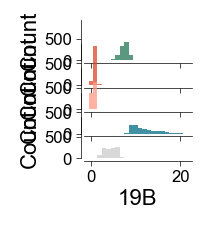

In [55]:
palette = [mnColor,excColor,lightExcColor,inhColor,"#cccccc"]

fig, axes = plt.subplots(5,1,sharex=True,sharey=True,gridspec_kw={"hspace":-0.4},)
fig.patch.set_alpha(0)
sns.histplot(nMnsActive_combined["none"],discrete=True,color=mnColor,ax=axes[0],edgecolor=None)
axes[0].patch.set_alpha(0)

sns.histplot(nMnsActive_combined["E1"],discrete=True,color=excColor,ax=axes[1],edgecolor=None)
axes[1].patch.set_alpha(0)

sns.histplot(nMnsActive_combined["E2"],discrete=True,color=lightExcColor,ax=axes[2],edgecolor=None)
axes[2].patch.set_alpha(0)

sns.histplot(nMnsActive_combined["I2"],discrete=True,color=inhColor,ax=axes[3],edgecolor=None)
axes[3].patch.set_alpha(0)

sns.histplot(nMnsActive_combined["19B"],discrete=True,color="#cccccc",ax=axes[4],edgecolor=None)
axes[4].patch.set_alpha(0)

sns.despine(offset=1,)

# plt.gca().set_yticks([0,500,1000])

fig.set_figwidth(0.7)
fig.set_figheight(0.9)

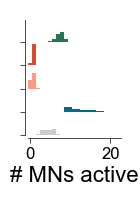

In [95]:
palette = [mnColor,excColor,lightExcColor,inhColor,"#cccccc"]

fig, axes = plt.subplots(5,1,sharex=True,sharey=True,gridspec_kw={"hspace":0.05},) #-0.4
fig.patch.set_alpha(0)
sns.histplot(nMnsActive_combined["none"],color=mnColor,ax=axes[0],edgecolor=None,discrete=plot_R_traces_stacked_by_module,alpha=1)
axes[0].patch.set_alpha(0)

sns.histplot(nMnsActive_combined["E1"],color=excColor,ax=axes[1],edgecolor=None,discrete=plot_R_traces_stacked_by_module,alpha=1)
axes[1].patch.set_alpha(0)

sns.histplot(nMnsActive_combined["E2"],color=lightExcColor,ax=axes[2],edgecolor=None,discrete=plot_R_traces_stacked_by_module,alpha=1)
axes[2].patch.set_alpha(0)

sns.histplot(nMnsActive_combined["I2"],color=inhColor,ax=axes[3],edgecolor=None,discrete=plot_R_traces_stacked_by_module,alpha=1)
axes[3].patch.set_alpha(0)

sns.histplot(nMnsActive_combined["19B"],color="#cccccc",ax=axes[4],edgecolor=None,discrete=plot_R_traces_stacked_by_module,alpha=1)
axes[4].patch.set_alpha(0)

sns.despine(offset=1)

# plt.gca().set_yticks([0,500,1000])
plt.xlabel("# MNs active")
plt.xlim([-0.5,22.5])
plt.yticks([0],labels=[])

fig.set_figwidth(0.6)
fig.set_figheight(0.75)
plt.ylabel("")

for i in range(4):
    axes[i].spines["bottom"].set_visible(False)
    axes[i].tick_params(axis="x",color="none")
    axes[i].set_ylabel("")

# fig.set_dpi(500)
if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnActiveStackedHists.svg",transparent=True)
plt.show()

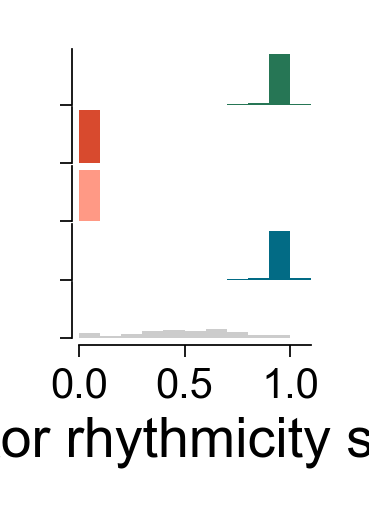

In [92]:
palette = [mnColor,excColor,lightExcColor,inhColor,"#cccccc"]

fig, axes = plt.subplots(5,1,sharex=True,sharey=True,gridspec_kw={"hspace":0.05},) #-0.4
fig.patch.set_alpha(0)
sns.histplot(simScore_combined["none"],color=mnColor,ax=axes[0],edgecolor=None,bins=np.arange(0,1.5,0.1),alpha=1)
axes[0].patch.set_alpha(0)

sns.histplot(simScore_combined["E1"],color=excColor,ax=axes[1],edgecolor=None,bins=np.arange(0,1.5,0.1),alpha=1)
axes[1].patch.set_alpha(0)

sns.histplot(simScore_combined["E2"],color=lightExcColor,ax=axes[2],edgecolor=None,bins=np.arange(0,1.5,0.1),alpha=1)
axes[2].patch.set_alpha(0)

sns.histplot(simScore_combined["I2"],color=inhColor,ax=axes[3],edgecolor=None,bins=np.arange(0,1.5,0.1),alpha=1)
axes[3].patch.set_alpha(0)

sns.histplot(simScore_combined["19B"],color="#cccccc",ax=axes[4],edgecolor=None,bins=np.arange(0,1.5,0.1),alpha=1)
axes[4].patch.set_alpha(0)

sns.despine(offset=1)

# plt.gca().set_yticks([0,500,1000])
plt.xlabel("motor rhythmicity score")
plt.xlim([0,1.1])
plt.xticks([0,0.5,1])
plt.yticks([0],labels=[])

fig.set_figwidth(0.6)
fig.set_figheight(0.75)
plt.ylabel("")

for i in range(4):
    axes[i].spines["bottom"].set_visible(False)
    axes[i].tick_params(axis="x",color="none")
    axes[i].set_ylabel("")

fig.set_dpi(500)
# if not os.path.exists(figFolder):
#     os.makedirs(figFolder)
# plt.savefig(figFolder+"/mnScoreStackedHists.svg",transparent=True)
plt.show()

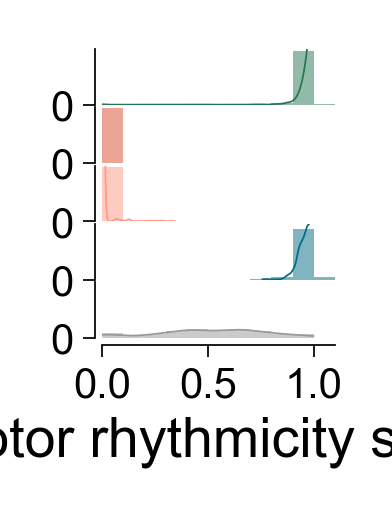

In [101]:
palette = [mnColor,excColor,lightExcColor,inhColor,"#999999"]

fig, axes = plt.subplots(5,1,sharex=True,sharey=True,gridspec_kw={"hspace":0.05},) #-0.4
fig.patch.set_alpha(0)
sns.histplot(simScore_combined["none"],color=palette[0],ax=axes[0],edgecolor=None,bins=np.arange(0,1.5,0.1),alpha=0.5,kde=True,line_kws={"linewidth":0.25,"alpha":1.0})
axes[0].patch.set_alpha(0)

sns.histplot(simScore_combined["E1"],color=palette[1],ax=axes[1],edgecolor=None,bins=np.arange(0,1.5,0.1),alpha=0.5,kde=True,line_kws={"linewidth":0.25,"alpha":1.0})
axes[1].patch.set_alpha(0)

sns.histplot(simScore_combined["E2"],color=palette[2],ax=axes[2],edgecolor=None,bins=np.arange(0,1.5,0.1),alpha=0.5,kde=True,line_kws={"linewidth":0.25,"alpha":1.0})
axes[2].patch.set_alpha(0)

sns.histplot(simScore_combined["I2"],color=palette[3],ax=axes[3],edgecolor=None,bins=np.arange(0,1.5,0.1),alpha=0.5,kde=True,line_kws={"linewidth":0.25,"alpha":1.0})
axes[3].patch.set_alpha(0)

sns.histplot(simScore_combined["19B"],color=palette[4],ax=axes[4],edgecolor=None,bins=np.arange(0,1.5,0.1),alpha=0.5,kde=True,line_kws={"linewidth":0.25,"alpha":1.0})
axes[4].patch.set_alpha(0)

sns.despine(offset=1)

# plt.gca().set_yticks([0,500,1000])
plt.xlabel("motor rhythmicity score")
plt.xlim([0,1.1])
plt.ylim([-1,1025])
plt.xticks([0,0.5,1])
plt.yticks([0],labels=[0])

fig.set_figwidth(0.6)
fig.set_figheight(0.75)
plt.ylabel("")

for i in range(4):
    axes[i].spines["bottom"].set_visible(False)
    axes[i].tick_params(axis="x",color="none")
    axes[i].set_ylabel("")

fig.set_dpi(500)
if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreStackedHistsKdes.svg",transparent=True)
plt.show()

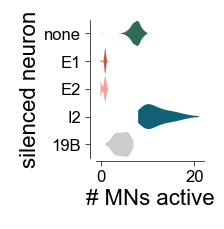

In [40]:
palette = [mnColor,excColor,lightExcColor,inhColor,"#cccccc"]

plt.figure(figsize=(0.7,0.9))
sns.violinplot(nMnsActive_combined,orient="h",palette=palette,edgecolor=None,inner=None,bw_adjust=2,cut=0,alpha=1.0,width=0.9)
# sns.boxplot(nMnsActive_combined,palette=palette,width=0.2,linewidth=0.75,fliersize=2**0.75,orient="h",
#             boxprops={"alpha":1.0,},showfliers=False)
# plt.xticks([0,5,10])
# plt.xlim([0,11])
sns.despine(offset={"left":2,"bottom":1})
plt.xlabel("# MNs active")
plt.ylabel("silenced neuron")

# plt.gcf().set_dpi(500)
if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnViolinAndBoxHorTaller.svg",transparent=True)
plt.show()

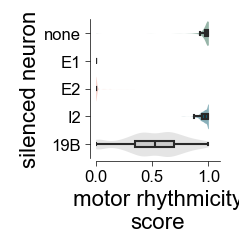

In [42]:
palette = [mnColor,excColor,lightExcColor,inhColor,"#cccccc"]

plt.figure(figsize=(0.8,0.9))

sns.violinplot(simScore_combined,palette=palette,linecolor="k",linewidth=0,inner=None,cut=0,alpha=0.5,orient="h",width=0.9)
sns.boxplot(simScore_combined,palette=palette,width=0.2,linewidth=0.75,fliersize=2**0.75,
            boxprops={"alpha":1.0,},showfliers=False,orient="h")
plt.xlim([0,1.1])
plt.xlabel("motor rhythmicity\nscore")
plt.xticks(np.arange(0,1.1,0.5))
plt.ylabel("silenced neuron")
sns.despine(offset={"left":2,"bottom":1})

# plt.gcf().set_dpi(500)
# if not os.path.exists(figFolder):
#     os.makedirs(figFolder)
# plt.savefig(figFolder+"/mnScoreViolinAndBoxHorTaller.svg",transparent=True)
plt.show()

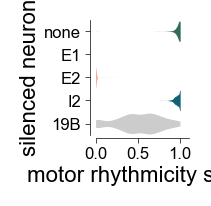

In [61]:
palette = [mnColor,excColor,lightExcColor,inhColor,"#cccccc"]

plt.figure(figsize=(0.6,0.75))

sns.violinplot(simScore_combined,palette=palette,linecolor="k",linewidth=0,inner=None,cut=0.0,alpha=1.0,orient="h",width=0.9,density_norm="area")
# sns.boxplot(simScore_combined,palette=palette,width=0.2,linewidth=0.75,fliersize=2**0.75,
#             boxprops={"alpha":1.0,},showfliers=False,orient="h")
plt.xlim([0,1.1])
plt.xlabel("motor rhythmicity score")
plt.xticks(np.arange(0,1.1,0.5))
plt.ylabel("silenced neuron")
sns.despine(offset={"left":2,"bottom":1})

# plt.gcf().set_dpi(500)

# if not os.path.exists(figFolder):
#     os.makedirs(figFolder)
# plt.savefig(figFolder+"/mnScoreViolin.svg",transparent=True)
plt.show()

In [45]:
nMnsActive_combined.to_csv(figFolder+"/nMnsActive.csv")
simScore_combined.to_csv(figFolder+"/scores.csv")

## MANC DNg100 core CPG only $|I_\text{stim}|$ sweep

In [11]:
simType = "DNg100_Stim_CoreCPG"
simPath = simType+"/hyak/run_id=28915018"
folder = dataPath + simPath
overallParams = DictConfig(load_from_yaml(folder+"/multirun.yaml"))
wTable = pd.read_csv("../"+overallParams.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])

nSims = overallParams.experiment.n_replicates
nActive = pd.DataFrame(index=np.arange(nSims))
nMnsActive = pd.DataFrame(index=np.arange(nSims))
simScore = pd.DataFrame(index=np.arange(nSims))
mnFreq = pd.DataFrame(index=np.arange(nSims))

subfolders = []
for f in os.listdir(folder):
    if os.path.isdir(f"{folder}/{f}"):
        subfolders.append(f)

/home/smpuglie/Pugliese_2025/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [12]:
# for subfolder in subfolders:
#     print(f"Loading {subfolder}")
#     Rs = sparse.load_npz(folder+f"/{subfolder}/ckpt/{simType}_Rs.npz").todense()
#     dataset = 0
#     Rs = Rs[dataset]
#     params = DictConfig(load_from_yaml(folder+f"/{subfolder}/.hydra/config.yaml"))
#     stimI = params.experiment.stimI[0]
#     for i in range(nSims):
#         # active neurons
#         R = Rs[i]
        
#         activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
#         nMnsActive.loc[i,stimI] = np.sum(activeMnsMask)
#         activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
#         score, freq = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
#         simScore.loc[i,stimI] = score
#         mnFreq.loc[i,stimI] = freq

# nMnsActive = nMnsActive.transpose().sort_index().transpose()
# simScore = simScore.transpose().sort_index().transpose()
# mnFreq = mnFreq.transpose().sort_index().transpose()

# figFolder = "../figures/"
# figFolder += "-".join(str.split(simPath,"/"))

In [13]:
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

nMnsActive = pd.read_csv(figFolder+"/nMnsActive.csv",index_col=0)
simScore = pd.read_csv(figFolder+"/scores.csv",index_col=0)
mnFreq = pd.read_csv(figFolder+"/frequencies.csv",index_col=0)

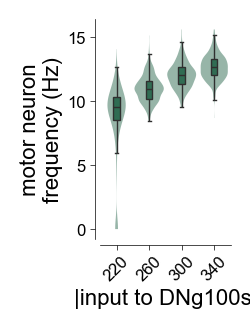

In [22]:
plt.figure(figsize=(0.84,1.426))
sns.violinplot((mnFreq/overallParams.sim.dt).iloc[:,1:].astype(float).melt(var_name="stimI",value_name="frequency"),x="stimI",y="frequency",edgecolor=None,inner=None,cut=0,alpha=0.5,color=mnColor,width=0.9)
sns.boxplot((mnFreq/overallParams.sim.dt).iloc[:,1:].astype(float).melt(var_name="stimI",value_name="frequency"),x="stimI",y="frequency",width=0.2,linewidth=0.5,fliersize=2**0.75,
            boxprops={"alpha":1.0,},showfliers=False,color=mnColor)
plt.gca().tick_params(axis='x', labelrotation=45)
sns.despine(offset=2)

plt.xlabel("|input to DNg100s|")
plt.ylabel("motor neuron\nfrequency (Hz)")
# plt.gcf().set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/mnFreqViolin.svg",transparent=True)
plt.show()

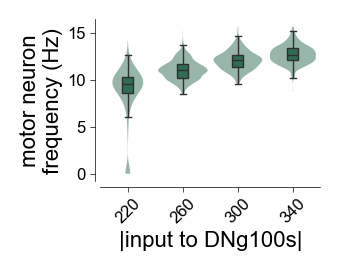

In [24]:
plt.figure(figsize=(1.42,1.05))
sns.violinplot((mnFreq/overallParams.sim.dt).iloc[:,1:].astype(float).melt(var_name="stimI",value_name="frequency"),x="stimI",y="frequency",edgecolor=None,inner=None,cut=0,alpha=0.5,color=mnColor,width=0.9)
sns.boxplot((mnFreq/overallParams.sim.dt).iloc[:,1:].astype(float).melt(var_name="stimI",value_name="frequency"),x="stimI",y="frequency",width=0.2,linewidth=0.5,fliersize=2**0.75,
            boxprops={"alpha":1.0,},showfliers=False,color=mnColor)
plt.gca().tick_params(axis='x', labelrotation=45)
sns.despine(offset=2)

plt.xlabel("|input to DNg100s|")
plt.ylabel("motor neuron\nfrequency (Hz)")
# plt.gcf().set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/mnFreqViolin_wide.svg",transparent=True)
plt.show()

In [ ]:
if not os.path.exists(figFolder):
    os.makedirs(figFolder)
nMnsActive.to_csv(figFolder+"/nMnsActive.csv")
simScore.to_csv(figFolder+"/scores.csv")
mnFreq.to_csv(figFolder+"/frequencies.csv")